In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import math
import os
import csv
from itertools import chain
from pprint import pprint
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# from scipy.stats import f_oneway
# from statsmodels.formula.api import ols
# import statsmodels.api as sm

# import statsmodels.formula.api as smf
# from patsy import contrasts

# ### Rattle_Newton
# import ThermaNewt.sim_snake_tb as therma_sim
# from scipy.spatial.distance import euclidean
# from fastdtw import fastdtw
# from sklearn.metrics import mean_squared_error


## Functions
def in_out_binary(in_out_value):
    if in_out_value=='In':
        val = 0
    else:
        val = 1
    return val

snake_name_to_id ={
    'Albert': 'EDCRVI003',
    'Cooper': 'EDCRVI004',
    'Eddie': 'EDCRVI001',
    'Hector': 'EDCRVI002',
    'Hunter': 'EDCRVI015',
    'Kokanee': 'EDCRVI013',
    'Manitoba': 'EDCRVI005',
    'Moose': 'EDCRVI006',
    'Paloma': 'EDCRVI016',
    'Victor': 'EDCRVI010',
    'Horace': 'NVCRVI037',
    'Ragnar': 'NVCRVI030',
    'Bonnie': 'MGCRVI021',
    'Caezar': 'MGCRVI015',
    'Cecilia': 'MGCRVI014',
    'Cher': 'MGCRVI013',
    'Cladwell': 'MGCRVI011',
    'Janis': 'MGCRVI010',
    'Nando': 'MGCRVI008',
    'Ringo': 'MGCRVI003',
    'Tornado': 'MGCRVI009'
}

impute = 'no'
snake_fp = '/home/mremington/Documents/therma_sim/therma_sim/Empirical_Data/snake_thermal_database.csv'

snake_db = pd.read_csv(snake_fp)
snake_db['Date'] = pd.to_datetime(snake_db['Date'])
snake_db.drop(columns=snake_db.columns[0], axis=1, inplace=True)
dead_snakes = ['Dusty', 'Bjorn']
snake_db = snake_db[~snake_db['Snake_Name'].isin(dead_snakes)]

## Filter out Winter
# overwintering = [10, 11, 12, 1, 2, 3, 4]
# filter_condition = ~snake_db['Date'].dt.month.isin(overwintering)
# snake_db = snake_db[filter_condition]
snake_db['Snake_ID'] = snake_db['Snake_Name'].map(snake_name_to_id)
#snake_db = pd.get_dummies(snake_db, columns=['Study_Site'], prefix='Study_Site')
snake_db.head()

,Date,Unit,Temperature,year,month,day,hour,minute,Study_Site,Snake_Name,file_name,Study_Site_Code,Snake_ID
0,2022-06-17 23:00:01,C,21.071,2022,6,17,23,0,Canada,Moose,Moose(EDCRVI006)2022_2023.csv,1,EDCRVI006
1,2022-06-18 00:10:01,C,21.071,2022,6,18,0,10,Canada,Moose,Moose(EDCRVI006)2022_2023.csv,1,EDCRVI006
2,2022-06-18 01:20:01,C,20.571,2022,6,18,1,20,Canada,Moose,Moose(EDCRVI006)2022_2023.csv,1,EDCRVI006
3,2022-06-18 02:30:01,C,20.571,2022,6,18,2,30,Canada,Moose,Moose(EDCRVI006)2022_2023.csv,1,EDCRVI006
4,2022-06-18 03:40:01,C,20.571,2022,6,18,3,40,Canada,Moose,Moose(EDCRVI006)2022_2023.csv,1,EDCRVI006


In [3]:
# Correct filepath usage
otm_fp = '/home/mremington/Documents/therma_sim/therma_sim/Empirical_Data/OTM_Main_Database.csv'

# Correct way to read it
otm_db = pd.read_csv(otm_fp)

# Optional: if your CSV was saved with index=True earlier and you have an extra first column,
# then you would drop the first unnamed column:
# otm_db = otm_db.drop(columns=otm_db.columns[0])

# Convert Date column back to datetime if needed
# otm_db['Date'] = pd.to_datetime(otm_db['Date'])

# Show preview
otm_db.sort_values('Date').head()


,Date,Unit,Temperature,year,month,day,hour,minute,Study_Site,Microhabitat,OTM_ID,file_name,Lat,Long,Astronomical_Season,SunMoon_Category,Simple_DayPeriod,Meteorological_Season,Study_Site_Code
416971,2021-06-14 18:30:01,C,19.554,2021,6,14,18,30,Texas,Unknown,BarnTempOffload1.csv,BarnTempOffload1.csv,30.322706,-103.136333,Spring,Noon,Night,Summer,3
416972,2021-06-14 18:35:01,C,20.054,2021,6,14,18,35,Texas,Unknown,BarnTempOffload1.csv,BarnTempOffload1.csv,30.322706,-103.136333,Spring,Noon,Night,Summer,3
416973,2021-06-14 18:40:01,C,20.555,2021,6,14,18,40,Texas,Unknown,BarnTempOffload1.csv,BarnTempOffload1.csv,30.322706,-103.136333,Spring,Noon,Night,Summer,3
416974,2021-06-14 18:45:01,C,21.555,2021,6,14,18,45,Texas,Unknown,BarnTempOffload1.csv,BarnTempOffload1.csv,30.322706,-103.136333,Spring,Noon,Night,Summer,3
416975,2021-06-14 18:50:01,C,21.555,2021,6,14,18,50,Texas,Unknown,BarnTempOffload1.csv,BarnTempOffload1.csv,30.322706,-103.136333,Spring,Noon,Night,Summer,3


In [4]:
# Pivot the DataFrame
otm_ts = otm_db.pivot_table(
    index=["Date", "year", "month", "day", "hour", "minute", "Study_Site", "Astronomical_Season", "SunMoon_Category", "Simple_DayPeriod",
           "Meteorological_Season", "Study_Site_Code"],
    columns="Microhabitat",
    values="Temperature"
).reset_index()

otm_ts.sort_values('Date').head()

Microhabitat,Date,year,month,day,hour,minute,Study_Site,Astronomical_Season,SunMoon_Category,Simple_DayPeriod,Meteorological_Season,Study_Site_Code,Air,Burrow,Grass,Open,Shrub,Unknown
0,2021-06-14 18:30:01,2021,6,14,18,30,Texas,Spring,Noon,Night,Summer,3,NaN,NaN,NaN,NaN,NaN,19.554
1,2021-06-14 18:35:01,2021,6,14,18,35,Texas,Spring,Noon,Night,Summer,3,NaN,NaN,NaN,NaN,NaN,20.054
2,2021-06-14 18:40:01,2021,6,14,18,40,Texas,Spring,Noon,Night,Summer,3,NaN,NaN,NaN,NaN,NaN,20.555
3,2021-06-14 18:45:01,2021,6,14,18,45,Texas,Spring,Noon,Night,Summer,3,NaN,NaN,NaN,NaN,NaN,21.555
4,2021-06-14 18:50:01,2021,6,14,18,50,Texas,Spring,Noon,Night,Summer,3,NaN,NaN,NaN,NaN,NaN,21.555


In [6]:
# unique_combinations = otm_ts[['Study_Site', 'Astronomical_Season','year']].drop_duplicates()
# print(unique_combinations)

In [5]:
# Thermal_ts

thermal_ts = pd.merge(
    left=snake_db,
    right=otm_ts,
    how='left',
    on=["Study_Site_Code", "year", "month", "day", "hour"]
)
thermal_ts = thermal_ts.rename(columns={
    'Date_x': 'Date',
    'minute_x': 'minute',
    'Study_Site_x': 'Study_Site',
    'Temperature': 'Body'
})

thermal_ts = thermal_ts.drop(columns=[
    'Date_y', 'minute_y', 'Study_Site_y'
])

thermal_ts.head()

,Date,Unit,Body,year,month,day,hour,minute,Study_Site,Snake_Name,...,Astronomical_Season,SunMoon_Category,Simple_DayPeriod,Meteorological_Season,Air,Burrow,Grass,Open,Shrub,Unknown
0,2022-06-17 23:00:01,C,21.071,2022,6,17,23,0,Canada,Moose,...,Spring,WaningGibbous,Night,Summer,22.580,18.8134,NaN,21.1220,21.633000,NaN
1,2022-06-18 00:10:01,C,21.071,2022,6,18,0,10,Canada,Moose,...,Spring,WaningGibbous,Night,Summer,20.579,18.1126,NaN,18.3690,18.963333,NaN
2,2022-06-18 01:20:01,C,20.571,2022,6,18,1,20,Canada,Moose,...,Spring,WaningGibbous,Night,Summer,21.079,18.0126,NaN,19.1205,19.965000,NaN
3,2022-06-18 02:30:01,C,20.571,2022,6,18,2,30,Canada,Moose,...,Spring,WaningGibbous,Night,Summer,19.077,17.0110,NaN,16.3660,17.628000,NaN
4,2022-06-18 03:40:01,C,20.571,2022,6,18,3,40,Canada,Moose,...,Spring,Sunset,Dusk,Summer,18.077,16.6102,NaN,15.3645,16.458667,NaN


In [8]:
###
# Make CSV
###

#thermal_ts.to_csv('/home/mremington/Documents/therma_sim/therma_sim/Empirical_Data/thermal_ts.csv', index=False)

In [9]:
# unique_combinations = thermal_ts[['hour_x', 'hour_y','year']].drop_duplicates()
# print(unique_combinations)

In [10]:
print(thermal_ts.columns)

Index(['Date', 'Unit', 'Body', 'year', 'month', 'day', 'hour', 'minute',
       'Study_Site', 'Snake_Name', 'file_name', 'Study_Site_Code', 'Snake_ID',
       'Astronomical_Season', 'SunMoon_Category', 'Simple_DayPeriod',
       'Meteorological_Season', 'Air', 'Burrow', 'Half', 'Open', 'Shrub'],
      dtype='object')


# EDA

In [6]:
# snake_db, thermal_ts
na_counts = (
    snake_db.groupby('Study_Site')['Temperature']
    .apply(lambda x: x.isna().sum())
    .reset_index(name='NA_Count')
)
print(na_counts)

  Study_Site  NA_Count
0     Canada         0
1   Nebraska         0
2      Texas         0


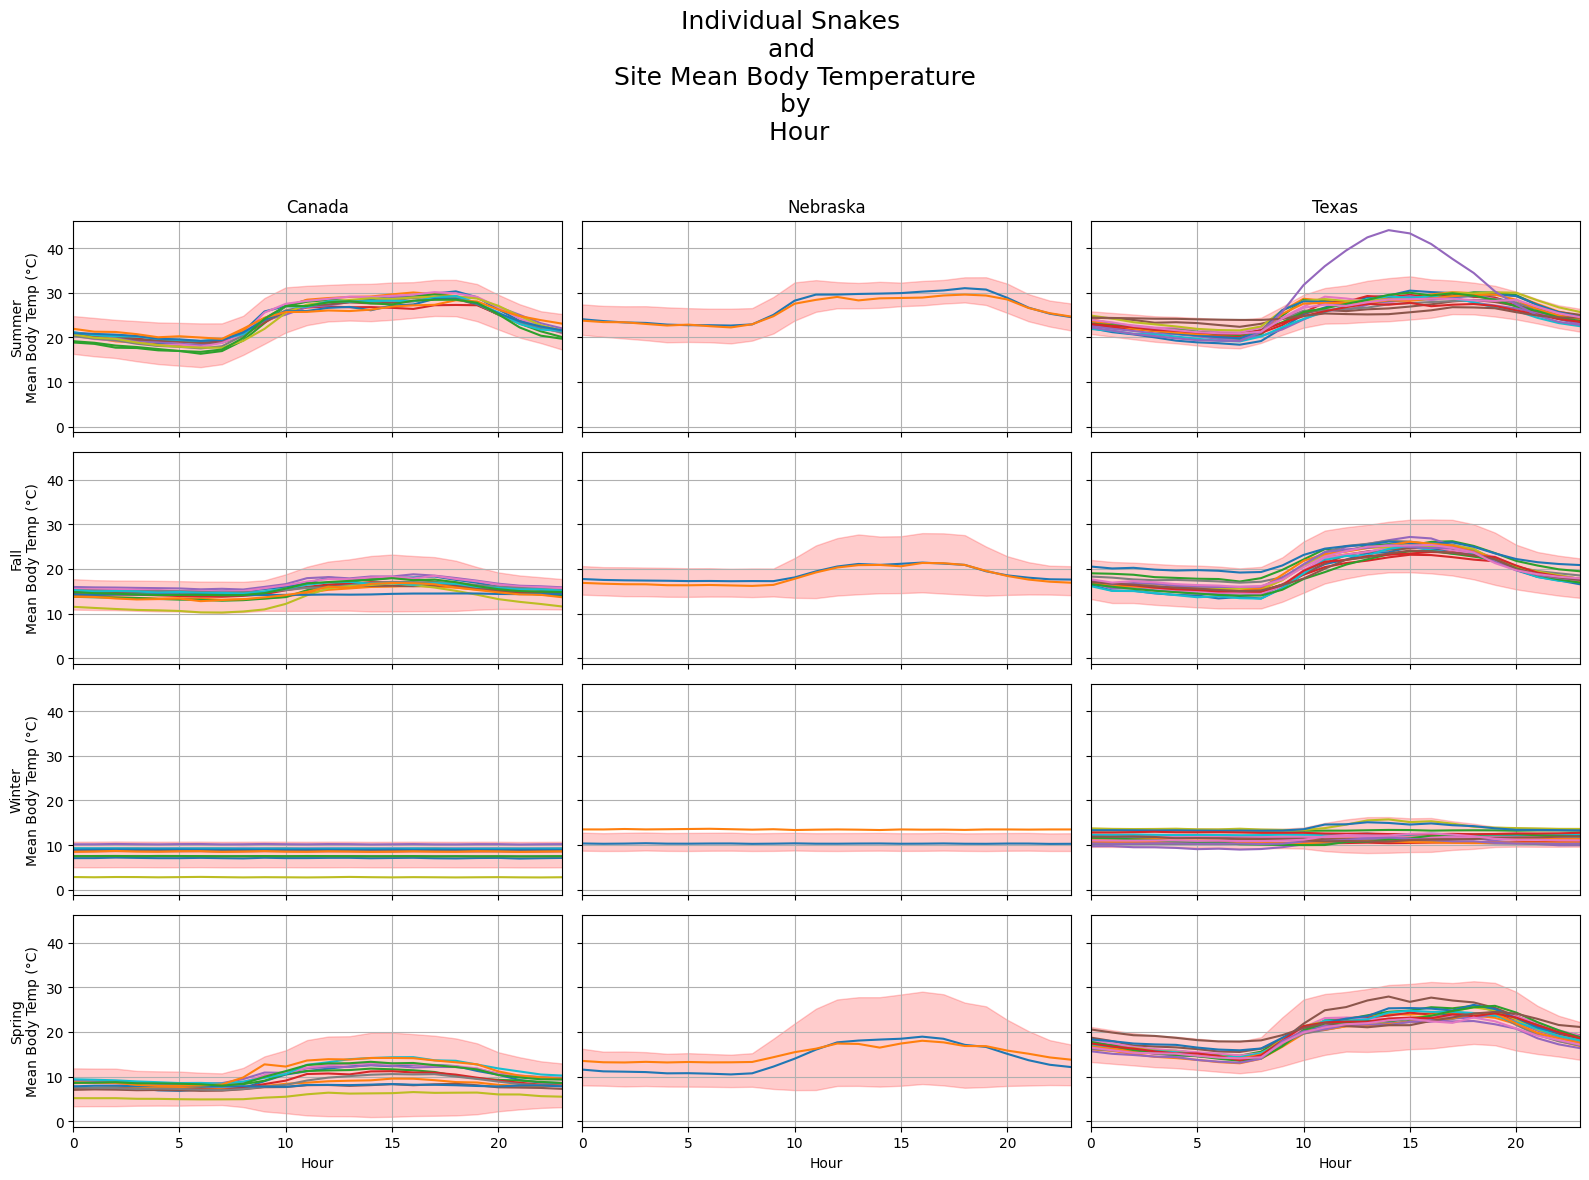

In [7]:
# Compute daily snake means, now grouped also by Meteorological_Season
daily_snake_means = (
    thermal_ts.groupby(['Study_Site', 'Meteorological_Season', 'Snake_Name', 'hour'])['Body']
    .mean()
    .reset_index(name='Daily_Snake_Body_Temp')
)
grouped = thermal_ts.groupby(['Study_Site', 'Meteorological_Season', 'hour'])['Body'].agg(['mean', 'std']).reset_index()
# Flip sites and seasons for the grid
sites = grouped['Study_Site'].unique()
seasons = ['Summer','Fall', 'Winter', 'Spring', ]

fig, axes = plt.subplots(len(seasons), len(sites), figsize=(16, 12), sharex=True, sharey=True)

for i, season in enumerate(seasons):
    for j, site in enumerate(sites):
        ax = axes[i, j]

        # Plot individual snake means, now filtered by BOTH site and season
        snake_subset = daily_snake_means[
            (daily_snake_means['Study_Site'] == site) &
            (daily_snake_means['Meteorological_Season'] == season)
        ]
        for snake_name, snake_data in snake_subset.groupby('Snake_Name'):
            ax.plot(
                snake_data['hour'], 
                snake_data['Daily_Snake_Body_Temp'], 
                alpha=1
            )

        # Plot overall site-season mean (still from your grouped summary)
        subset = grouped[
            (grouped['Study_Site'] == site) &
            (grouped['Meteorological_Season'] == season)
        ]
        if not subset.empty:
            x = subset['hour'].values
            y = subset['mean'].values
            yerr = subset['std'].values
            #ax.plot(x, y, color='red', label='Site Mean Body Temp', linewidth=2)
            ax.fill_between(x, y - yerr, y + yerr, color='red', alpha=0.2)

        if i == len(seasons) - 1:
            ax.set_xlabel('Hour')
        if j == 0:
            ax.set_ylabel(f'{season}\nMean Body Temp (°C)')
        if i == 0:
            ax.set_title(site)

        ax.set_xlim(0, 23)
        ax.grid(True)
plt.savefig("/home/mremington/Documents/therma_sim/therma_sim/src/therma_sim/Results/Figures/individual_bt.png", bbox_inches='tight')
fig.suptitle('Individual Snakes \n and  \n Site Mean Body Temperature \n by \n Hour', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [8]:
# Step 1: Daily mean per snake
daily_snake_means = (
    snake_db.groupby(['Study_Site', 'Snake_Name', 'year', 'month', 'day', 'hour', 'Date'])['Temperature']
    .mean()
    .reset_index(name='Daily_Snake_Body_Temp')
)

# Step 2: Daily mean across snakes (equal-weighted) per site
daily_site_means = (
    daily_snake_means.groupby(['Study_Site', 'year', 'month', 'day', 'hour', 'Date'])['Daily_Snake_Body_Temp']
    .mean()
    .reset_index(name='Daily_Site_Mean_Temp')
)

# Step 3: Final overall mean and std per site

mean_body_temp_by_site = (
    thermal_ts.groupby('Study_Site')['Body']
    .agg(
        Count='count',
        Mean_Snake_Body_Temp='mean',
        Std_Snake_Body_Temp='std',
        Min_Temperature='min',
        Q10_Temperature=lambda x: x.quantile(0.10),
        Q25_Temperature=lambda x: x.quantile(0.25),
        Median_Temperature='median',
        Q75_Temperature=lambda x: x.quantile(0.75),
        Q90_Temperature=lambda x: x.quantile(0.90),
        Max_Temperature='max',
    )
    .reset_index()
)

# Now calculate Standard Error
mean_body_temp_by_site['SE_Snake_Body_Temp'] = (
    mean_body_temp_by_site['Std_Snake_Body_Temp'] / np.sqrt(mean_body_temp_by_site['Count'])
)
print(mean_body_temp_by_site)

  Study_Site   Count  Mean_Snake_Body_Temp  Std_Snake_Body_Temp  \
0     Canada  180189             13.843988             8.121471   
1   Nebraska   26011             17.920523             8.280191   
2      Texas  267703             21.133662             6.947349   

   Min_Temperature  Q10_Temperature  Q25_Temperature  Median_Temperature  \
0           -3.950            5.585            7.135              11.601   
1            4.577            8.090           10.088              16.119   
2            2.027           11.593           15.104              21.663   

   Q75_Temperature  Q90_Temperature  Max_Temperature  SE_Snake_Body_Temp  
0           19.103           26.633           41.581            0.019132  
1           25.125           30.119           37.593            0.051341  
2           26.559           29.624           77.776            0.013427  


In [9]:
## Seasonal Stats
mean_body_temp_by_site_and_season = (
    thermal_ts.groupby([ 'Meteorological_Season', 'Study_Site'])['Body']
    .agg(
        Count='count',
        Mean_Snake_Body_Temp='mean',
        Std_Snake_Body_Temp='std',
        Min_Temperature='min',
        Q10_Temperature=lambda x: x.quantile(0.10),
        Q25_Temperature=lambda x: x.quantile(0.25),
        Median_Temperature='median',
        Q75_Temperature=lambda x: x.quantile(0.75),
        Q90_Temperature=lambda x: x.quantile(0.90),
        Max_Temperature='max',
    )
    .reset_index()
)

# Now calculate Standard Error
# Calculate Standard Error of the Mean (SEM)
mean_body_temp_by_site_and_season['SE_Snake_Body_Temp'] = (
    mean_body_temp_by_site_and_season['Std_Snake_Body_Temp'] / 
    np.sqrt(mean_body_temp_by_site_and_season['Count'])
)

# Print or inspect result
print(mean_body_temp_by_site_and_season)


   Meteorological_Season Study_Site   Count  Mean_Snake_Body_Temp  \
0                   Fall     Canada   40909             14.982166   
1                   Fall   Nebraska    5312             18.565693   
2                   Fall      Texas   43126             19.927842   
3                 Spring     Canada   37249              8.655885   
4                 Spring   Nebraska    3803             14.370071   
5                 Spring      Texas   43506             19.472471   
6                 Summer     Canada   39329             23.717349   
7                 Summer   Nebraska    8153             26.461559   
8                 Summer      Texas  133632             25.097182   
9                 Winter     Canada   40681              7.870097   
10                Winter   Nebraska    2054             10.696113   
11                Winter      Texas   42879             11.794052   

    Std_Snake_Body_Temp  Min_Temperature  Q10_Temperature  Q25_Temperature  \
0              4.632901 

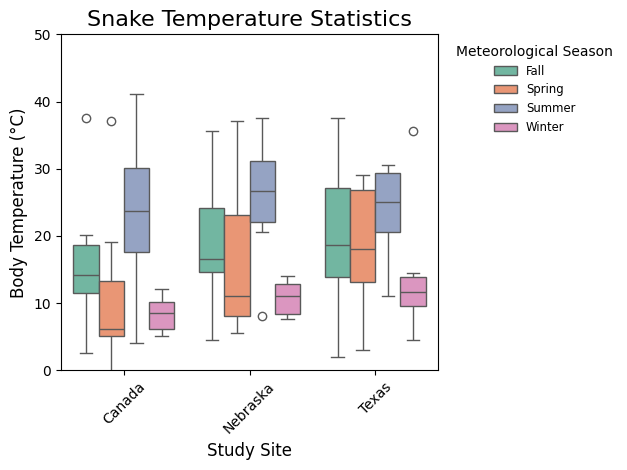

In [10]:
melted_data = mean_body_temp_by_site_and_season.melt(
    id_vars=['Meteorological_Season', 'Study_Site'],
    value_vars=['Min_Temperature', 'Q10_Temperature', 'Q25_Temperature', 'Median_Temperature', 
                'Q75_Temperature', 'Q90_Temperature', 'Max_Temperature'],
    var_name='Temperature_Statistic',
    value_name='Temperature'
)

# Create the box plot
sns.boxplot(
    data=melted_data,
    x='Study_Site',
    y='Temperature',
    hue='Meteorological_Season',
    palette='Set2'
)

# Customize the plot
plt.title('Snake Temperature Statistics', fontsize=16)
plt.xlabel('Study Site', fontsize=12)
plt.ylabel('Body Temperature (°C)', fontsize=12)
plt.legend(
    title='Meteorological Season',
    loc='upper left',
    bbox_to_anchor=(1.02, 1),
    fontsize='small',        # or e.g. 8
    title_fontsize='medium', # optional: sets legend title size
    frameon=False
)

plt.ylim(0, 50)
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig("/home/mremington/Documents/therma_sim/therma_sim/src/therma_sim/Results/Figures/Bodytemp_bp_by_szn.png", bbox_inches='tight')
# Show the plot
plt.show()

In [12]:
thermal_ts.head()

,Date,Unit,Body,year,month,day,hour,minute,Study_Site,Snake_Name,...,Snake_ID,Astronomical_Season,SunMoon_Category,Simple_DayPeriod,Meteorological_Season,Air,Burrow,Half,Open,Shrub
0,2022-06-17 23:00:01,C,21.071,2022,6,17,23,0,Canada,Moose,...,EDCRVI006,Spring,WaningGibbous,Night,Summer,22.580,17.1365,19.931333,21.1220,21.633000
1,2022-06-18 00:10:01,C,21.071,2022,6,18,0,10,Canada,Moose,...,EDCRVI006,Spring,WaningGibbous,Night,Summer,20.579,17.1365,18.763333,18.3690,18.963333
2,2022-06-18 01:20:01,C,20.571,2022,6,18,1,20,Canada,Moose,...,EDCRVI006,Spring,WaningGibbous,Night,Summer,21.079,16.8865,18.763333,19.1205,19.965000
3,2022-06-18 02:30:01,C,20.571,2022,6,18,2,30,Canada,Moose,...,EDCRVI006,Spring,WaningGibbous,Night,Summer,19.077,16.6355,17.261333,16.3660,17.628000
4,2022-06-18 03:40:01,C,20.571,2022,6,18,3,40,Canada,Moose,...,EDCRVI006,Spring,Sunset,Dusk,Summer,18.077,16.3850,16.760333,15.3645,16.458667


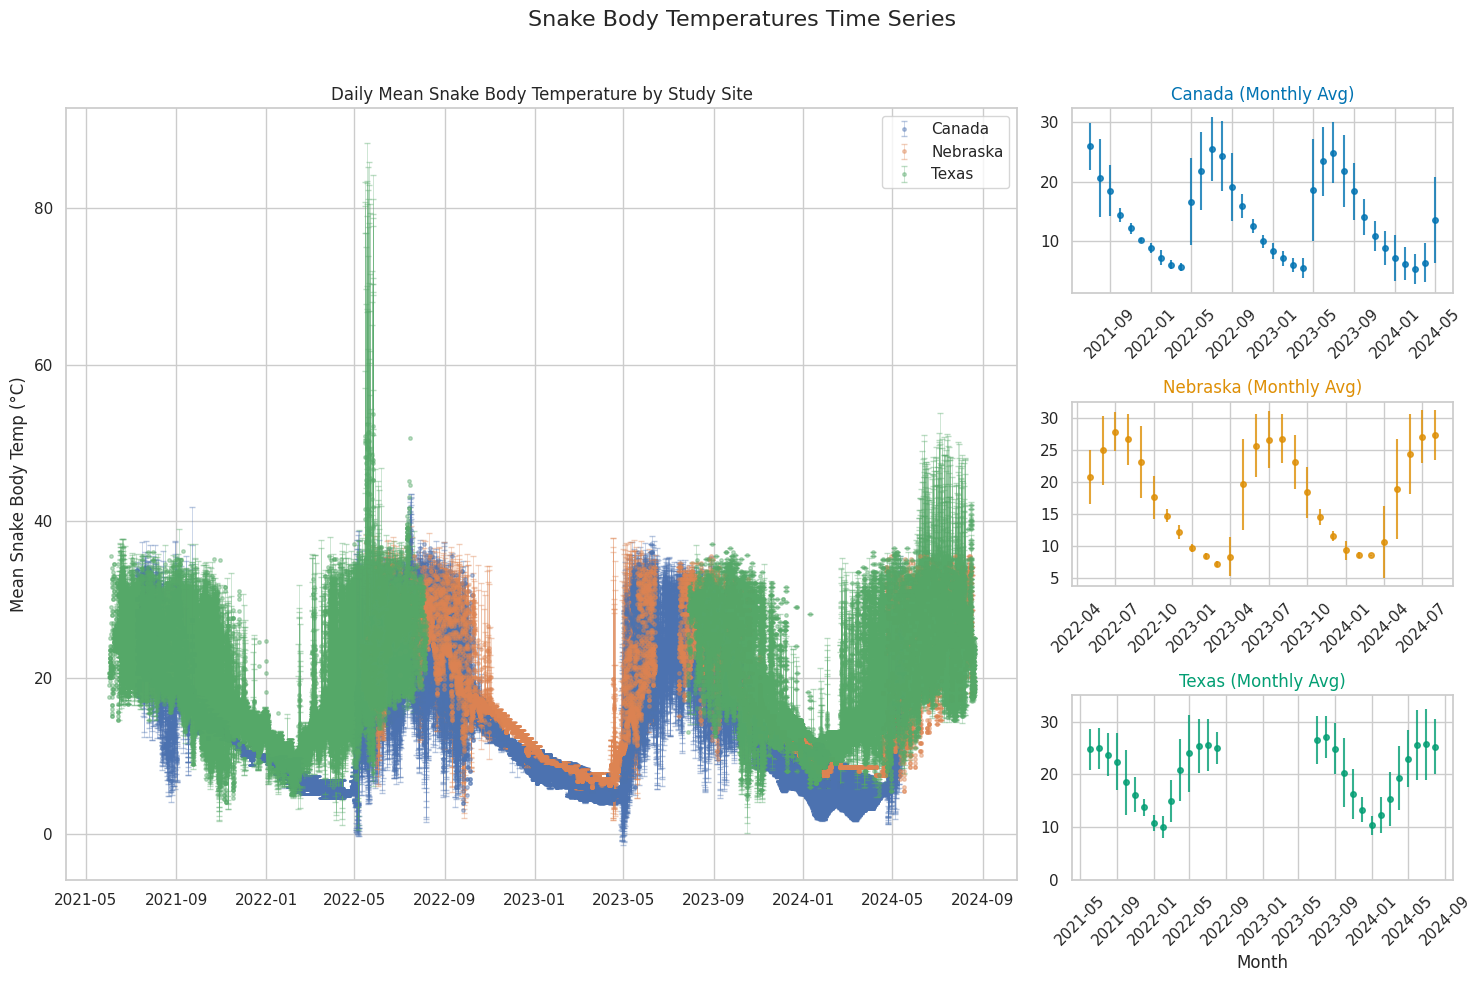

In [11]:
# Recompute with daily mean + std per site
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

# Recompute with daily mean + std per site
daily_summary = (
    thermal_ts.groupby(['Study_Site', 'Date'])['Body']
    .agg(['mean', 'std'])
    .reset_index()
    .rename(columns={'mean': 'Daily_Mean_Temp', 'std': 'Daily_Std_Temp'})
)

monthly_summary = (
    thermal_ts.groupby(['Study_Site', 'month', 'year'])['Body']
    .agg(['mean', 'std'])
    .reset_index()
    .rename(columns={'mean': 'Monthly_Mean_Temp', 'std': 'Monthly_Std_Temp'})
)
monthly_summary['YearMonth'] = pd.to_datetime(
    monthly_summary[['year', 'month']].assign(day=1)
)

# === Create composite layout ===
sns.set(style="whitegrid")
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 2, width_ratios=[2.5, 1], height_ratios=[1, 1, 1])
plt.subplots_adjust(hspace=0.4)

# Left: Daily errorbar scatter
ax_all = plt.subplot(gs[:, 0])
for site, group in daily_summary.groupby('Study_Site'):
    ax_all.errorbar(
        group['Date'],
        group['Daily_Mean_Temp'],
        yerr=group['Daily_Std_Temp'],
        fmt='o',
        markersize=2.5,
        elinewidth=0.5,
        capsize=2,
        alpha=0.4,
        label=site
    )
ax_all.set_title('Daily Mean Snake Body Temperature by Study Site')
ax_all.set_ylabel('Mean Snake Body Temp (°C)')
ax_all.legend()

# Right: Monthly summaries per site
palette = sns.color_palette("colorblind")
site_colors = {
    'Canada': palette[0],    # Blue
    'Nebraska': palette[1],  # Orange
    'Texas': palette[2]      # Green
}

# Right: Monthly summaries per site with custom colors
for i, site in enumerate(monthly_summary['Study_Site'].unique()):
    ax = plt.subplot(gs[i, 1])
    group = monthly_summary[monthly_summary['Study_Site'] == site]
    ax.errorbar(
        group['YearMonth'],
        group['Monthly_Mean_Temp'],
        yerr=group['Monthly_Std_Temp'],
        fmt='o',
        markersize=4,
        alpha=0.8,
        color=site_colors.get(site, 'black')  # fallback to black
    )
    ax.set_title(f"{site} (Monthly Avg)", color=site_colors.get(site))
    if i == 2:
        ax.set_xlabel("Month")
        ax.set_ylim(0,35)
    ax.tick_params(axis='x', rotation=45)



fig.suptitle("Snake Body Temperatures Time Series", fontsize=16)
plt.savefig("/home/mremington/Documents/therma_sim/therma_sim/src/therma_sim/Results/Figures/Bodytemp_timeseries.png", bbox_inches='tight')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [17]:
# This needs some work but is interesting
import seaborn as sns
import pandas as pd

# # Choose months to include (e.g., July, August, September)
# overwintering = [10, 11, 12, 1, 2, 3, 4]
# months_to_include = [5,6,7, 8, 9]

# # Make sure the Month column exists
# daily_snake_means['Month'] = pd.to_datetime(daily_snake_means['Date']).dt.month

# # Filter by selected months
# filtered_data = daily_snake_means[daily_snake_means['Month'].isin(months_to_include)]

# # Recompute daily summary stats after filtering
# daily_summary = (
#     filtered_data.groupby(['Study_Site', 'Date'])['Daily_Snake_Body_Temp']
#     .agg(['mean', 'std'])
#     .reset_index()
#     .rename(columns={'mean': 'Daily_Mean_Temp', 'std': 'Daily_Std_Temp'})
# )

# # Optional: define max gap (in days) to break plots into chunks
# max_gap_days = 30
# daily_summary['Date'] = pd.to_datetime(daily_summary['Date'])

# # Plot each site individually
# for site, site_group in daily_summary.groupby('Study_Site'):
#     site_group = site_group.sort_values('Date').reset_index(drop=True)
#     site_group['Date_Diff'] = site_group['Date'].diff().dt.days
#     site_group['Chunk'] = (site_group['Date_Diff'] > max_gap_days).cumsum().fillna(0)

#     for chunk_id, chunk_data in site_group.groupby('Chunk'):
#         if len(chunk_data) < 5:
#             continue

#         plt.figure(figsize=(10, 5))
#         plt.errorbar(
#             chunk_data['Date'],
#             chunk_data['Daily_Mean_Temp'],
#             yerr=chunk_data['Daily_Std_Temp'],
#             fmt='o',
#             alpha=0.8,
#             capsize=3,
#             markersize=1 
#         )
#         plt.xlabel('Date')
#         plt.ylabel('Mean Snake Body Temp (°C)')
#         plt.title(f'{site} – Daily Mean Snake Body Temp (±1 Std Dev), Months: {months_to_include}')
#         plt.tight_layout()
#         plt.show()



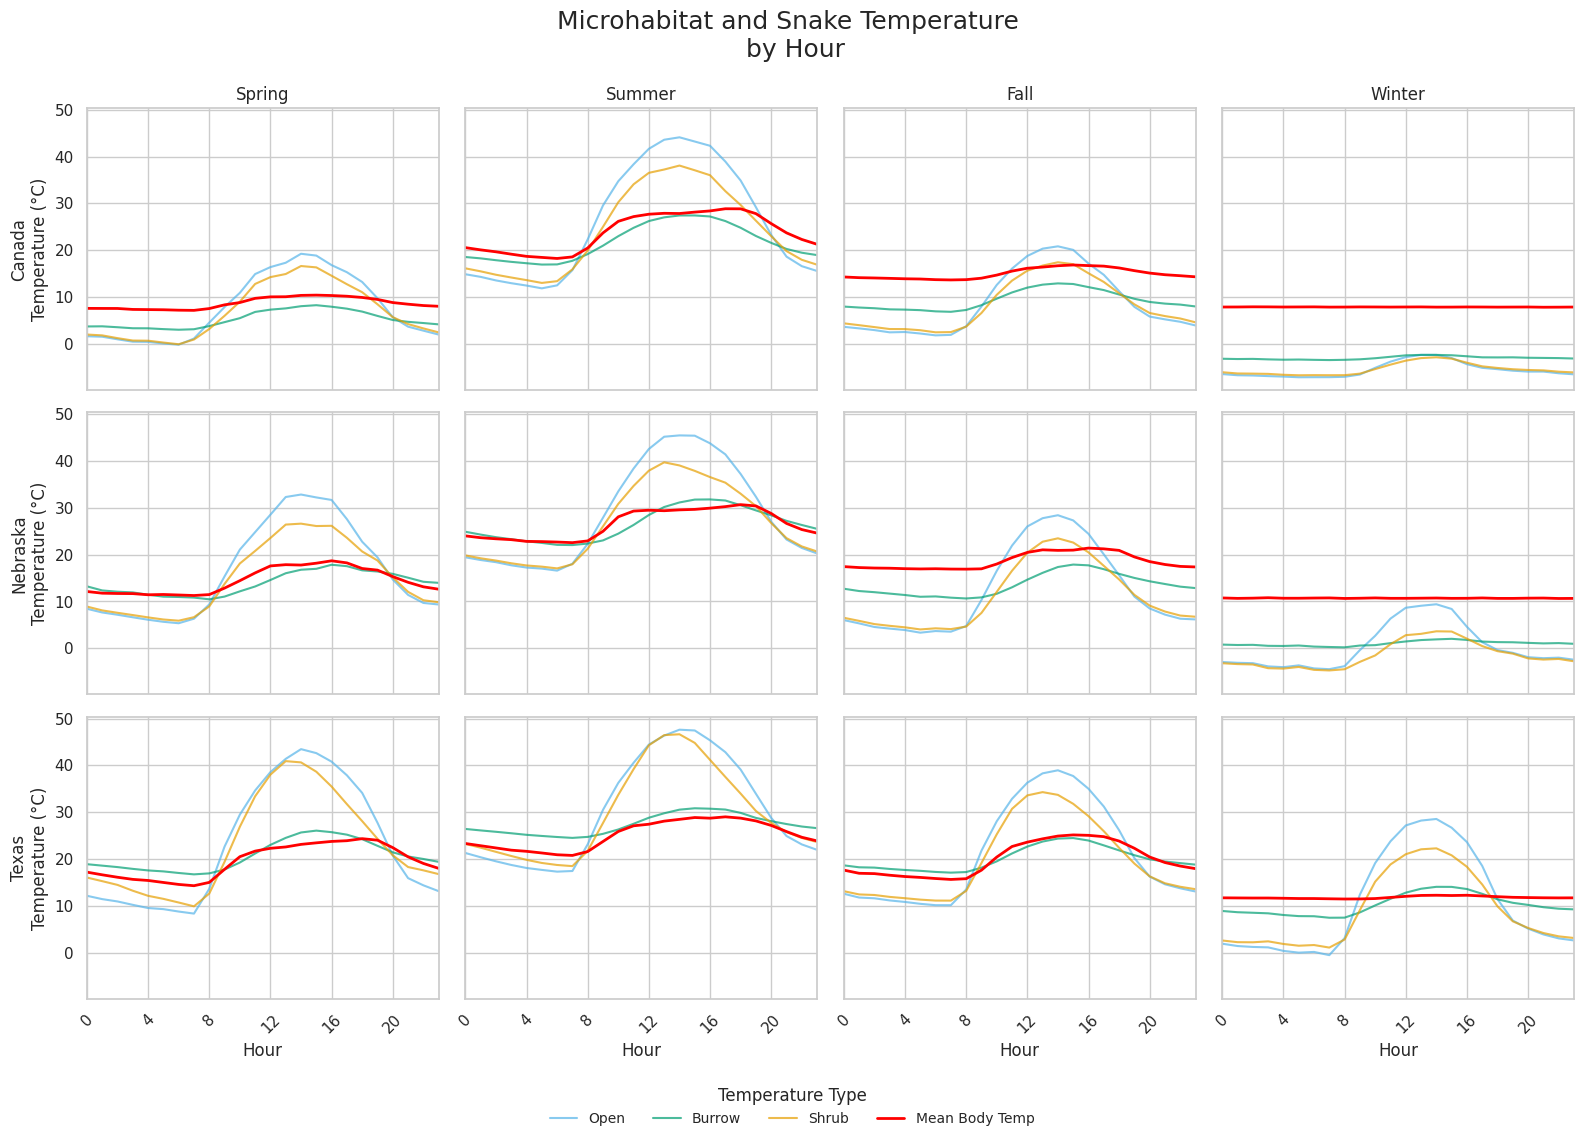

In [12]:
# Plot grid: meteorological season (rows) × site (columns)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Group data by hour, site, and season to compute mean temperatures
grouped = (
    thermal_ts.groupby(['Study_Site', 'Meteorological_Season', 'hour'])[
        ['Body', 'Open', 'Burrow', 'Shrub']
    ]
    .mean()
    .reset_index()
    .rename(columns={'Body': 'Mean_Body_Temp'})
)

# Define plotting parameters
sites = ['Canada', 'Nebraska', 'Texas']
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

fig, axes = plt.subplots(len(sites), len(seasons), figsize=(16, 12), sharex=True, sharey=True)
habitat_colors = {
    'Open': '#56B4E9',      # Sky blue
    'Burrow': '#009E73',    # Bluish green
    'Shrub': '#E69F00'      # Orange
}

# Plot grid: rows = sites, columns = seasons
for i, site in enumerate(sites):
    for j, season in enumerate(seasons):
        ax = axes[i, j]

        # Subset the grouped data
        subset = grouped[
            (grouped['Study_Site'] == site) &
            (grouped['Meteorological_Season'] == season)
        ]

        if not subset.empty:
            # Plot each habitat temperature
            for habitat in ['Open', 'Burrow', 'Shrub']:
                ax.plot(
                    subset['hour'],
                    subset[habitat],
                    label=habitat,
                    color=habitat_colors[habitat],
                    alpha=0.7
                )

            # Plot mean body temperature
            ax.plot(
                subset['hour'],
                subset['Mean_Body_Temp'],
                color='red',
                label='Mean Body Temp',
                linewidth=2
            )

        # Labeling
        if i == len(sites) - 1:
            ax.set_xlabel('Hour')
        if j == 0:
            ax.set_ylabel(f'{site}\nTemperature (°C)')
        if i == 0:
            ax.set_title(season)

        ax.set_xlim(0, 23)
        ax.set_xticks(range(0, 24, 4))
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True)

# Create a single global legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    ncol=4,
    bbox_to_anchor=(0.5, -0.01),
    fontsize='small',
    title='Temperature Type',
    title_fontsize='medium',
    frameon=False
)

# Title and layout
plt.savefig("/home/mremington/Documents/therma_sim/therma_sim/src/therma_sim/Results/Figures/mh_bt_hour.png", bbox_inches='tight')
fig.suptitle('Microhabitat and Snake Temperature \n by Hour', fontsize=18, y=0.93)
plt.tight_layout(rect=[0, 0.04, 1, 0.94])
plt.show()



In [61]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # Define your colorblind-friendly palette for sites
# site_colors = {
#     'Canada': '#E69F00',   # orange
#     'Nebraska': '#56B4E9', # sky blue
#     'Texas': '#009E73'     # bluish green
# }

# # Prepare the data for plotting
# habitat_data = thermal_ts.melt(
#     id_vars=['Study_Site', 'Meteorological_Season', 'hour'],
#     value_vars=['Open', 'Burrow', 'Shrub'],
#     var_name='Habitat',
#     value_name='Temperature'
# )

# # Set up the grid of plots: one row per season
# seasons = ['Summer', 'Fall', 'Winter', 'Spring']
# fig, axes = plt.subplots(len(seasons), 3, figsize=(10, 16), sharex=True, sharey=True)

# for i, season in enumerate(seasons):
#     ax = axes[i]
#     subset = habitat_data[habitat_data['Meteorological_Season'] == season]
#     if not subset.empty:
#         sns.boxplot(
#             x='Habitat',
#             y='Temperature',
#             hue='Study_Site',
#             data=subset,
#             palette=site_colors,
#             ax=ax
#         )
#         ax.set_title(f'{season}')
#         ax.set_xlabel('Microhabitat')
#         ax.set_ylabel('Temperature (°C)')
#         ax.legend(title='Site', loc='upper right')
#     else:
#         ax.set_visible(False)

# plt.suptitle('Temperature Distributions by Microhabitat and Site (Meteorological Seasons)', fontsize=18, y=0.92)
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.show()


# Thermal Stats

In [ ]:
# 40 - 45 is a ct max
# 0 ctmin
# 90 quartile for volintary max
# vt max
# Burrow loggers are not deep torper, reflective of summer retreat burrow


def get_vt_range_kubisch(tb_series):
    """
    VTmin and VTmax defined as first and third quartiles of selected Tb (Kubisch et al. 2016).
    
    Parameters:
    - tb_series: pd.Series of body temperatures (Tb)
    
    Returns:
    - vt_min: float, Q1 (25th percentile)
    - vt_max: float, Q3 (75th percentile)
    """
    vt_min = tb_series.quantile(0.25)
    vt_max = tb_series.quantile(0.75)
    return vt_min, vt_max

def get_vt_range_camacho(tb_series):
    """
    VTmin and VTmax defined as absolute min and max tolerated Tb (Camacho et al. 2018).
    
    Parameters:
    - tb_series: pd.Series of body temperatures (Tb)
    
    Returns:
    - vt_min: float, minimum tolerated Tb
    - vt_max: float, maximum tolerated Tb
    """
    vt_min = tb_series.min()
    vt_max = tb_series.max()
    return vt_min, vt_max


# Torper

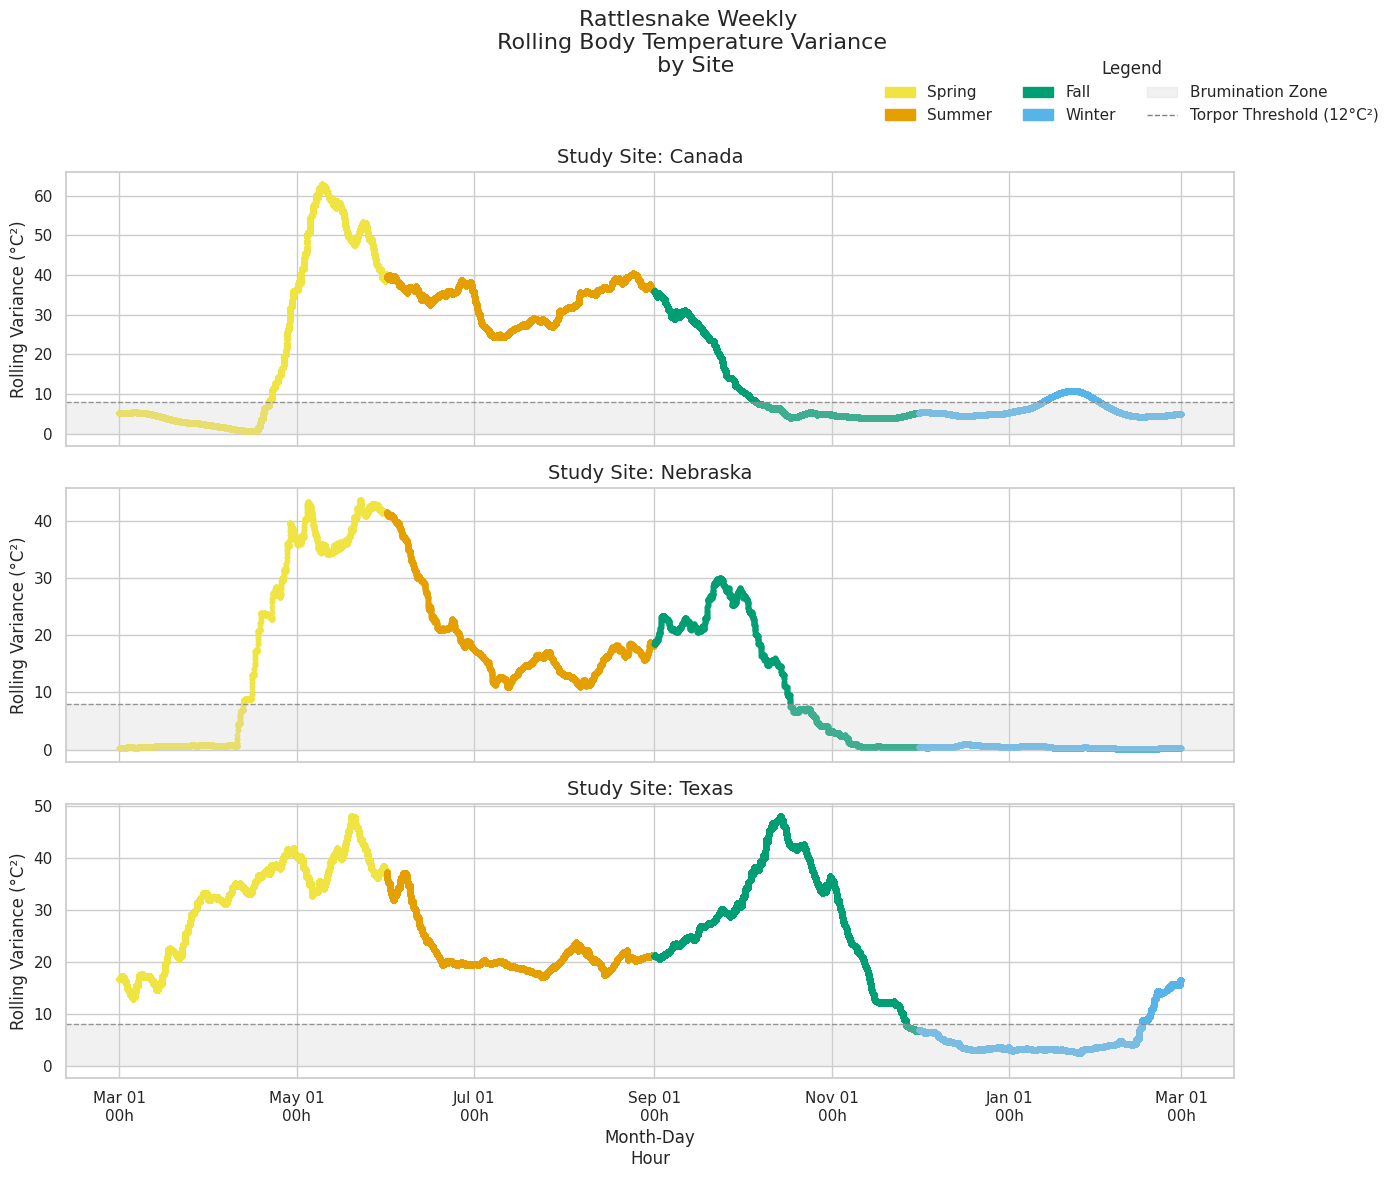

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Step 1: Sort and create dummy-year datetime for rolling
thermal_ts_sorted = thermal_ts.sort_values(by=['Study_Site', 'month', 'day', 'hour'])

# Normalize season names
thermal_ts_sorted['Meteorological_Season'] = thermal_ts_sorted['Meteorological_Season'].str.strip().str.capitalize()

# Assign dummy year for plotting (Spring–Fall = 2020, Winter Jan–Feb = 2021)
thermal_ts_sorted['plot_year'] = thermal_ts_sorted.apply(
    lambda row: 2021 if (row['Meteorological_Season'] == 'Winter' and row['month'] <= 2) else 2020,
    axis=1
)

# Create datetime for rolling — safe with error handling
thermal_ts_sorted['datetime'] = pd.to_datetime({
    'year': 2000,
    'month': thermal_ts_sorted['month'],
    'day': thermal_ts_sorted['day'],
    'hour': thermal_ts_sorted['hour']
}, errors='coerce')

# Create datetime for plotting — using dummy year, safely
thermal_ts_sorted['plot_datetime'] = pd.to_datetime({
    'year': thermal_ts_sorted['plot_year'],
    'month': thermal_ts_sorted['month'],
    'day': thermal_ts_sorted['day'],
    'hour': thermal_ts_sorted['hour']
}, errors='coerce')

# Drop rows with invalid datetime (e.g. Feb 30)
thermal_ts_sorted.dropna(subset=['datetime', 'plot_datetime'], inplace=True)

# Step 2: Compute rolling population-level variance across all snakes per site
rolling_variance = (
    thermal_ts_sorted
    .sort_values(by=['Study_Site', 'datetime'])
    .groupby('Study_Site')
    .rolling(window='14D', on='datetime', center=True)['Body']
    .var()
    .reset_index(name='Rolling_Var')
)

# Step 3: Merge metadata including plot_datetime and season
metadata = thermal_ts_sorted[['Study_Site', 'datetime', 'plot_datetime', 'month', 'day', 'hour', 'Meteorological_Season']].drop_duplicates()
rolling_variance = rolling_variance.merge(metadata, on=['Study_Site', 'datetime'], how='left')

# Step 4: Normalize season ordering
season_order = ['Spring', 'Summer', 'Fall', 'Winter']
rolling_variance['Meteorological_Season'] = pd.Categorical(
    rolling_variance['Meteorological_Season'],
    categories=season_order,
    ordered=True
)

# Define season colors
season_colors = {
    'Spring': '#F0E442',
    'Summer': '#E69F00',
    'Fall': '#009E73',
    'Winter': '#56B4E9'
}

# Add brumination flag column
brumination_temp = 8
rolling_variance['Brumination'] = (rolling_variance['Rolling_Var'] <= brumination_temp).astype(int)

# Step 5: Plotting
sites = rolling_variance['Study_Site'].unique()
fig, axes = plt.subplots(len(sites), 1, figsize=(14, 4 * len(sites)), sharex=True)

if len(sites) == 1:
    axes = [axes]

for i, site in enumerate(sites):
    ax = axes[i]
    site_data = rolling_variance[rolling_variance['Study_Site'] == site]

    for season in season_order:
        season_data = site_data[site_data['Meteorological_Season'] == season]
        if not season_data.empty:
            ax.scatter(
                season_data['plot_datetime'],
                season_data['Rolling_Var'],
                color=season_colors.get(season, 'gray'),
                alpha=0.6,
                s=10
            )

    # Brumination shading and threshold line
    ax.axhspan(0, brumination_temp, color='lightgrey', alpha=0.3)
    ax.axhline(y=brumination_temp, color='gray', linestyle='--', linewidth=1, alpha=0.8)

    ax.set_title(f'Study Site: {site}', fontsize=14)
    ax.set_ylabel('Rolling Variance (°C²)')
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d\n%Hh'))

axes[-1].set_xlabel('Month-Day\nHour')
fig.suptitle('Rattlesnake Weekly \n Rolling Body Temperature Variance \n by Site', fontsize=16)

# Step 6: Manual custom legend
season_patches = [mpatches.Patch(color=color, label=season) for season, color in season_colors.items()]
brum_zone_patch = mpatches.Patch(color='lightgrey', alpha=0.3, label='Brumination Zone')
torpor_line = mlines.Line2D([], [], color='gray', linestyle='--', linewidth=1, label='Torpor Threshold (12°C²)')
scatter_dot = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=5, label='Rolling Variance')

custom_legend = season_patches + [brum_zone_patch, torpor_line]

fig.legend(
    handles=custom_legend,
    loc='upper right',
    bbox_to_anchor=(1, .95),
    ncol=3,
    frameon=False,
    title='Legend'
)
plt.savefig("/home/mremington/Documents/therma_sim/therma_sim/src/therma_sim/Results/Figures/torper_periods.png", bbox_inches='tight')
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


In [29]:
rolling_variance = rolling_variance.drop_duplicates(subset=['Study_Site', 'datetime'])
rolling_variance = rolling_variance.dropna(subset=['Meteorological_Season'])
brum_hours = rolling_variance[rolling_variance['Brumination'] == 1][['Study_Site', 'month', 'day', 'hour', 'Meteorological_Season']]

rolling_variance.head()

,Study_Site,datetime,Rolling_Var,plot_datetime,month,day,hour,Meteorological_Season,Brumination
0,Canada,2000-01-01 00:00:00,5.447484,2021-01-01 00:00:00,1,1,0,Winter,1
52,Canada,2000-01-01 01:00:00,5.459887,2021-01-01 01:00:00,1,1,1,Winter,1
96,Canada,2000-01-01 02:00:00,5.467282,2021-01-01 02:00:00,1,1,2,Winter,1
146,Canada,2000-01-01 03:00:00,5.474349,2021-01-01 03:00:00,1,1,3,Winter,1
198,Canada,2000-01-01 04:00:00,5.481792,2021-01-01 04:00:00,1,1,4,Winter,1


In [30]:
brum_days = (
    rolling_variance[rolling_variance['Brumination'] == 1]
    .drop_duplicates(subset=['Study_Site', 'month', 'day'])[['Study_Site', 'month', 'day']]
    .sort_values(['Study_Site', 'month', 'day'])
)

# Get unique (month, day) where Brumination != 1 by site
non_brum_days = (
    rolling_variance[rolling_variance['Brumination'] != 1]
    .drop_duplicates(subset=['Study_Site', 'month', 'day'])[['Study_Site', 'month', 'day']]
    .sort_values(['Study_Site', 'month', 'day'])
)
brum_days.head()

,Study_Site,month,day
0,Canada,1,1
1025,Canada,1,2
2013,Canada,1,3
3026,Canada,1,4
4059,Canada,1,5


In [38]:
import json
import os

# Brumination dates
brum_days['month_day'] = list(zip(brum_days['month'], brum_days['day']))

# Group by site and convert to list
brumination_dates_by_site = brum_days.groupby('Study_Site')['month_day'].unique()

# Convert to a regular dictionary with sorted lists
brumination_dict = {site: sorted(dates.tolist()) for site, dates in brumination_dates_by_site.items()}

# Print lists by site
for site, dates in brumination_dict.items():
    print(f"\n{site} Brumination Dates ({len(dates)} days):")
    date_strs = [f"{month:02d}-{day:02d}" for month, day in dates]
    print(', '.join(date_strs))

# Save each site's list to a separate JSON file
output_dir = '/home/mremington/Documents/therma_sim/therma_sim/src/therma_sim/job_and_config_files/'
os.makedirs(output_dir, exist_ok=True)

for site, dates in brumination_dict.items():
    # Replace spaces or special characters with underscores if needed
    safe_site = site.replace(' ', '_').replace('/', '_')
    filepath = os.path.join(output_dir, f'brumination_dates_{safe_site}.json')

    # Option 1: Save as list of tuples
    # with open(filepath, 'w') as f:
    #     json.dump({site: dates}, f, indent=4)

    # Option 2: Save as list of MM-DD strings (easier to read)
    date_strs = [f"{month:02d}-{day:02d}" for month, day in dates]
    with open(filepath, 'w') as f:
        json.dump({site: date_strs}, f, indent=4)



Canada Brumination Dates (179 days):
01-01, 01-02, 01-03, 01-04, 01-05, 01-06, 01-07, 01-08, 01-09, 01-10, 01-11, 01-12, 02-01, 02-02, 02-03, 02-04, 02-05, 02-06, 02-07, 02-08, 02-09, 02-10, 02-11, 02-12, 02-13, 02-14, 02-15, 02-16, 02-17, 02-18, 02-19, 02-20, 02-21, 02-22, 02-23, 02-24, 02-25, 02-26, 02-27, 02-28, 03-01, 03-02, 03-03, 03-04, 03-05, 03-06, 03-07, 03-08, 03-09, 03-10, 03-11, 03-12, 03-13, 03-14, 03-15, 03-16, 03-17, 03-18, 03-19, 03-20, 03-21, 03-22, 03-23, 03-24, 03-25, 03-26, 03-27, 03-28, 03-29, 03-30, 03-31, 04-01, 04-02, 04-03, 04-04, 04-05, 04-06, 04-07, 04-08, 04-09, 04-10, 04-11, 04-12, 04-13, 04-14, 04-15, 04-16, 04-17, 04-18, 04-19, 04-20, 04-21, 10-06, 10-07, 10-08, 10-09, 10-10, 10-11, 10-12, 10-13, 10-14, 10-15, 10-16, 10-17, 10-18, 10-19, 10-20, 10-21, 10-22, 10-23, 10-24, 10-25, 10-26, 10-27, 10-28, 10-29, 10-30, 10-31, 11-01, 11-02, 11-03, 11-04, 11-05, 11-06, 11-07, 11-08, 11-09, 11-10, 11-11, 11-12, 11-13, 11-14, 11-15, 11-16, 11-17, 11-18, 11-19, 11-

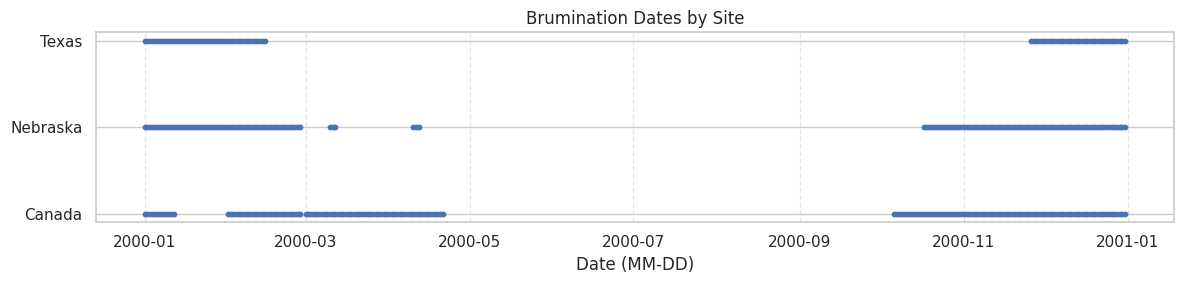

In [34]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming brumination_dict from previous step
# e.g., {'Canada': ['01-01', '01-02', ...], 'Texas': [...], ...}

# Flatten into a DataFrame for easy plotting
plot_df = pd.DataFrame([
    {"Site": site, "Date": date}
    for site, dates in brumination_dict.items()
    for date in dates
])

# Convert MM-DD to datetime object for plotting (year is arbitrary, e.g., 2000)
plot_df["Datetime"] = pd.to_datetime("2000-" + plot_df["Date"], format="%Y-%m-%d")

# Sort for clean plotting
plot_df = plot_df.sort_values(by="Datetime")

# Create a categorical mapping for y-axis (one row per site)
site_order = list(brumination_dict.keys())
site_to_y = {site: i for i, site in enumerate(site_order)}
plot_df["y"] = plot_df["Site"].map(site_to_y)

# Plot
plt.figure(figsize=(12, 3))
plt.scatter(plot_df["Datetime"], plot_df["y"], s=10)

# Format plot
plt.yticks(list(site_to_y.values()), list(site_to_y.keys()))
plt.xlabel("Date (MM-DD)")
plt.title("Brumination Dates by Site")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


In [66]:
# Non brumination dates
non_brum_days['month_day'] = non_brum_days['month'].astype(str).str.zfill(2) + '-' + non_brum_days['day'].astype(str).str.zfill(2)

# Group by site and convert to list
non_brumination_dates_by_site = non_brum_days.groupby('Study_Site')['month_day'].unique()

# Print lists by site
for site, dates in non_brumination_dates_by_site.items():
    print(f"\n{site} non_Brumination Dates ({len(dates)} days):")
    print(', '.join(sorted(dates)))


Canada non_Brumination Dates (160 days):
04-23, 04-24, 04-25, 04-26, 04-27, 04-28, 04-29, 04-30, 05-01, 05-02, 05-03, 05-04, 05-05, 05-06, 05-07, 05-08, 05-09, 05-10, 05-11, 05-12, 05-13, 05-14, 05-15, 05-16, 05-17, 05-18, 05-19, 05-20, 05-21, 05-22, 05-23, 05-24, 05-25, 05-26, 05-27, 05-28, 05-29, 05-30, 05-31, 06-01, 06-02, 06-03, 06-04, 06-05, 06-06, 06-07, 06-08, 06-09, 06-10, 06-11, 06-12, 06-13, 06-14, 06-15, 06-16, 06-17, 06-18, 06-19, 06-20, 06-21, 06-22, 06-23, 06-24, 06-25, 06-26, 06-27, 06-28, 06-29, 06-30, 07-01, 07-02, 07-03, 07-04, 07-05, 07-06, 07-07, 07-08, 07-09, 07-10, 07-11, 07-12, 07-13, 07-14, 07-15, 07-16, 07-17, 07-18, 07-19, 07-20, 07-21, 07-22, 07-23, 07-24, 07-25, 07-26, 07-27, 07-28, 07-29, 07-30, 07-31, 08-01, 08-02, 08-03, 08-04, 08-05, 08-06, 08-07, 08-08, 08-09, 08-10, 08-11, 08-12, 08-13, 08-14, 08-15, 08-16, 08-17, 08-18, 08-19, 08-20, 08-21, 08-22, 08-23, 08-24, 08-25, 08-26, 08-27, 08-28, 08-29, 08-30, 08-31, 09-01, 09-02, 09-03, 09-04, 09-05, 09-06,

In [43]:
hour_counts_by_site = (
    rolling_variance
    .groupby(['Study_Site', 'Brumination'], observed=True)
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: 'Active_Hours', 1: 'Brumination_Hours'})
)

hour_counts_by_site['Brumination_%'] = 100 * hour_counts_by_site['Brumination_Hours'] / (
    hour_counts_by_site['Active_Hours'] + hour_counts_by_site['Brumination_Hours']
)
hour_counts_by_site = hour_counts_by_site.round(1)
print(hour_counts_by_site)


Brumination  Active_Hours  Brumination_Hours  Brumination_%
Study_Site                                                 
Canada               3758               4950           56.8
Nebraska             3701               4364           54.1
Texas                 866                284           24.7


In [39]:
summary = (
    rolling_variance
    .groupby(['Study_Site', 'Meteorological_Season', 'Brumination'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={0: 'Active_Hours', 1: 'Brumination_Hours'})
)
print(summary)


Brumination                       Active_Hours  Brumination_Hours
Study_Site Meteorological_Season                                 
Canada     Spring                          871               1285
           Summer                         2208                  0
           Fall                            679               1505
           Winter                            0               2160
Nebraska   Spring                          646                946
           Summer                         1985                144
           Fall                           1070               1114
           Winter                            0               2160
Texas      Spring                          305                  0
           Summer                          225                  0
           Fall                            290                 22
           Winter                           46                262


/tmp/ipykernel_10844/1248733080.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Study_Site', 'Meteorological_Season', 'Brumination'])
